In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from time import time

import numpy as np
import pandas as pd
import xarray as xr
from sklearn.linear_model import LinearRegression
from scipy import signal
import xrscipy.signal as dsp

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

import gsw

from niwtools.tools import *
from niwtools.qc import *
from epsilon_tools import *

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

purp = pd.read_pickle('../data/purp_colormap.pkl')
# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

xr.set_options(display_style="text", display_width=100,warn_for_unclosed_files=True);

/usr/local/anaconda3/lib/python3.7/site-packages/distributed/utils.py:138: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  RuntimeWarning,


In [3]:
raw = xr.open_dataset('../data/raw_temp.nc')
raw = raw.drop(['lon','lat','pressure'])

## Find b'

In [94]:
raw['b_prime'] = raw.n2.mean('time')*raw.eta.rolling(time=18).mean()
raw['b_prime'] = raw.b_prime - raw.b_prime.mean('time')

(-200, 0)

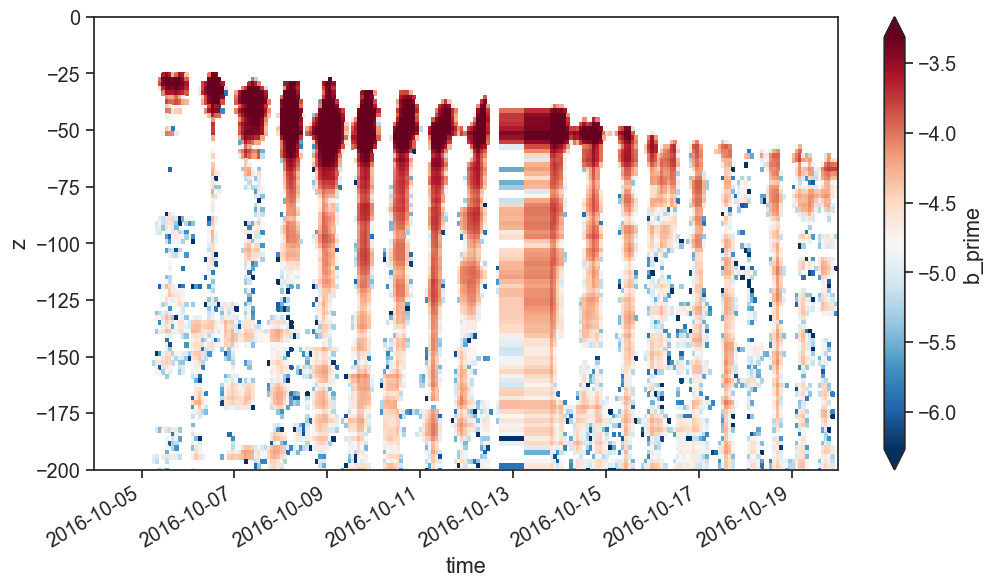

In [95]:
raw.b_prime.pipe(np.log10).plot(robust=True, cmap='RdBu_r')
plt.ylim(-200,0)

## Compute p'

$
b' = - N^2\eta \\
p'(z) = \int_z^0 b'dz' - \frac{1}{H}\int_{-H}^0  \int_{z}^0 b'dz'dz
$

In [96]:
tliste=[]
for ti, t in enumerate(raw.time):
    temp = raw.isel(time=ti)
    
    liste=[]
    for zi, z in enumerate( temp.z):
        if temp.b_prime.isel(z=zi).notnull():
            term_a = integral( temp.b_prime, z, 0)
            term_a['z'] = z
            liste.append(term_a)
        else:
            liste.append( np.nan)

    cleanedList = [x for x in liste if type(x)!=float]
    
    if cleanedList:
        new = xr.concat(cleanedList, dim='z')
#         new = new - new.integrate('z')/new.z.max() 

        tliste.append(new)
    
pprime = xr.concat(tliste, dim='time')

In [97]:
tliste=[]
for ti, t in enumerate(pprime.time):
    temp = pprime.isel(time=ti)
    
    term_b = -integral( temp, temp.z.min(), 0)/ temp.z.min()
    tliste.append(term_b)
    
pprime_b = xr.concat(tliste, dim='time')

In [134]:
prime0 = pprime - pprime_b

(-200, 0)

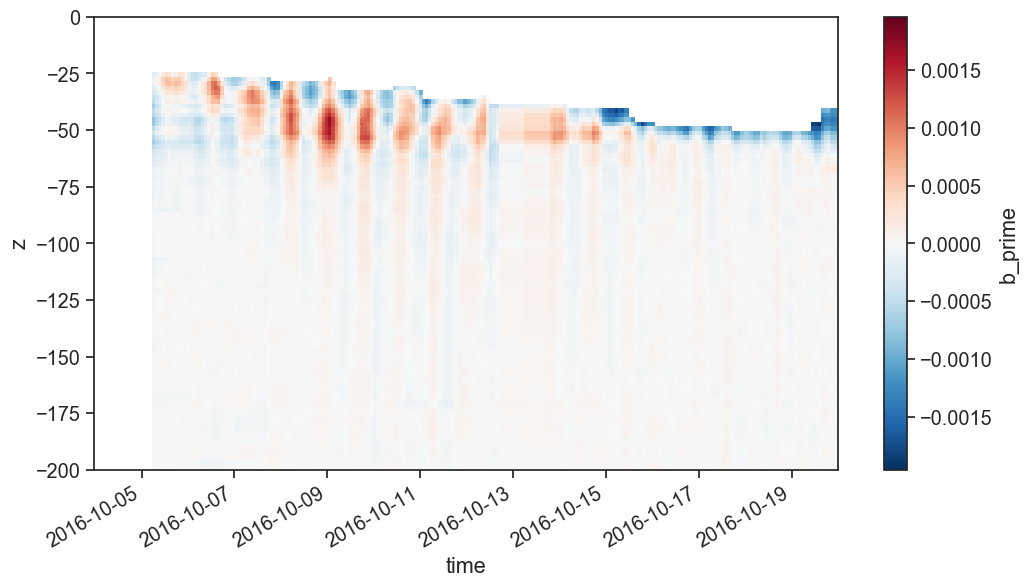

In [135]:
raw.b_prime.plot()
plt.ylim(-200,0)

(-200, 0)

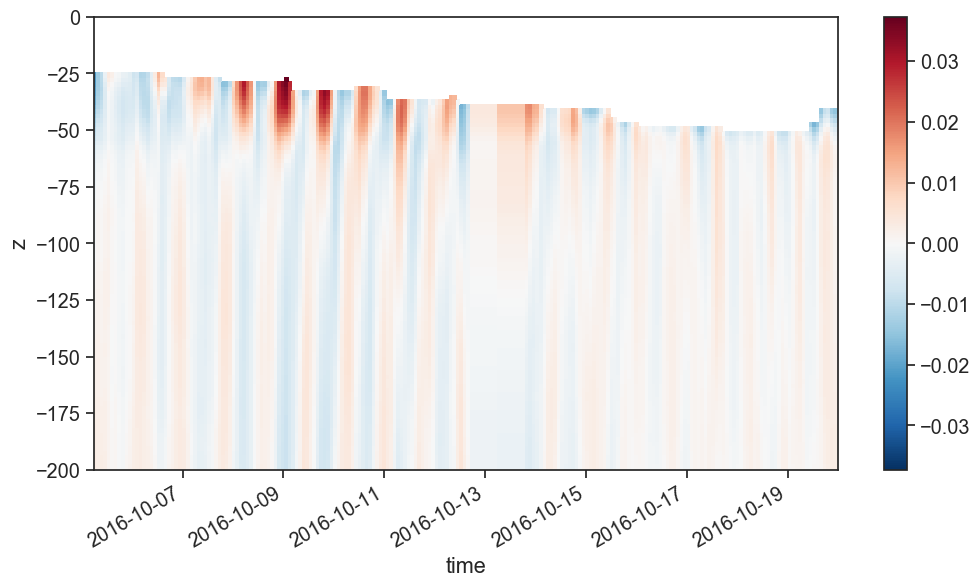

In [136]:
prime0.transpose().plot()
plt.ylim(-200,0)

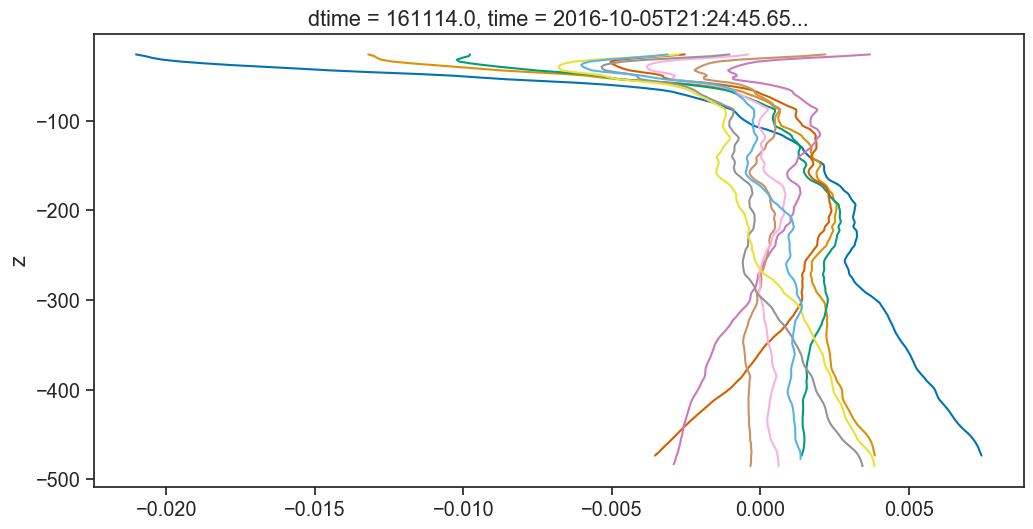

In [137]:
for i in range(10):
    prime0.isel(time=i).plot(y='z')

### Compute u'p'

In [138]:
uprime = raw.uNI
vprime = raw.vNI

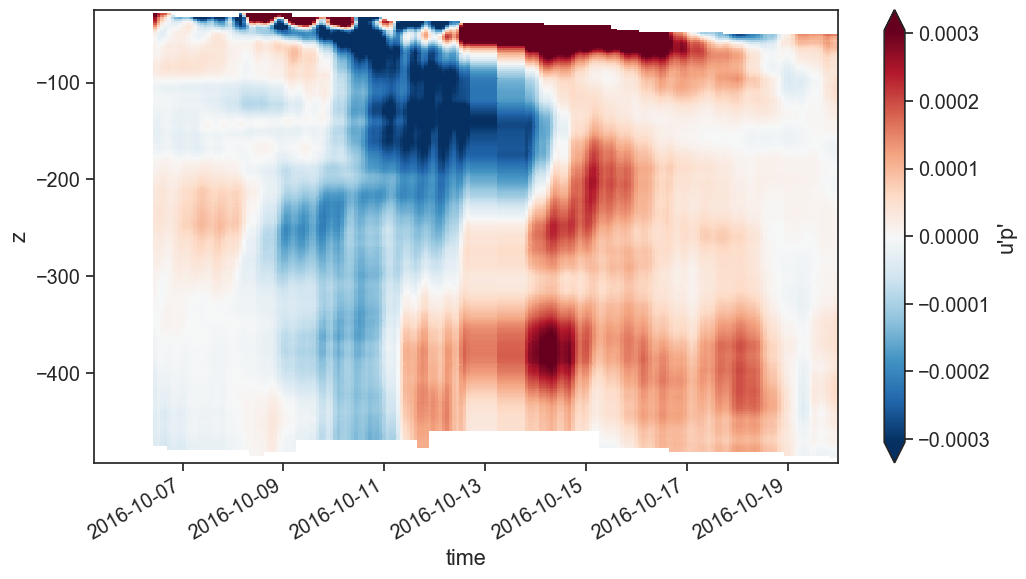

In [139]:
(uprime*prime0).rolling(time=18).mean().plot(robust=True,
                    cbar_kwargs={'label':"u'p'"})

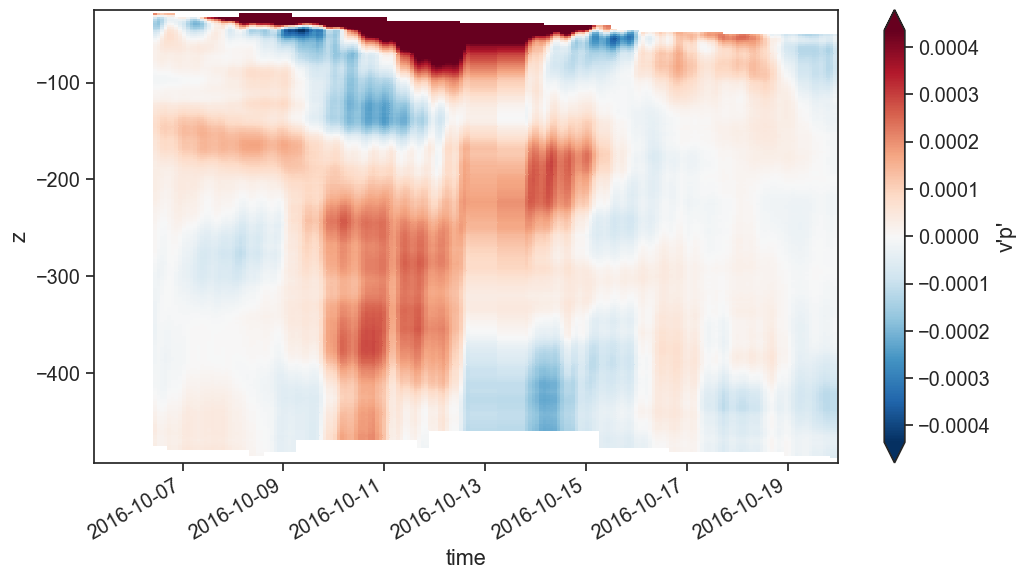

In [140]:
(vprime*prime0).rolling(time=18).mean().plot(robust=True,
                    cbar_kwargs={'label':"v'p'"})

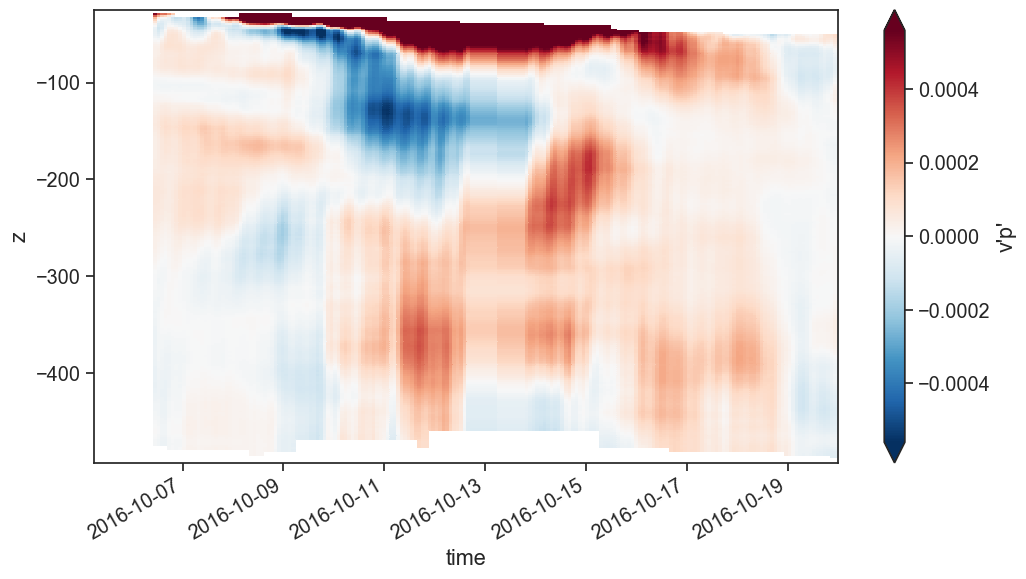

In [141]:
(uprime*prime0 + (vprime*prime0)).rolling(time=18).mean().plot(robust=True,
                    cbar_kwargs={'label':"v'p'"})

### Compute w'

In [142]:
wprime = raw.eta.differentiate('time', datetime_unit='s')

(-500, 0)

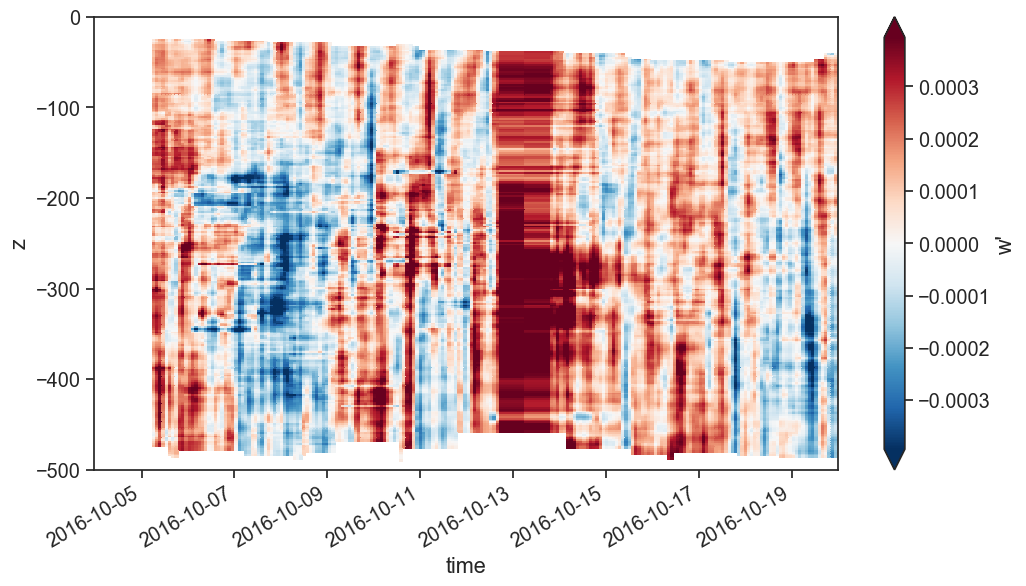

In [143]:
wprime.rolling(time=18).mean().plot(robust=True,
                    cbar_kwargs={'label':"w'"})
plt.ylim(-500,0)

In [144]:
(wprime*prime0).min()

<xarray.DataArray ()>
array(-4.61359914e-05)

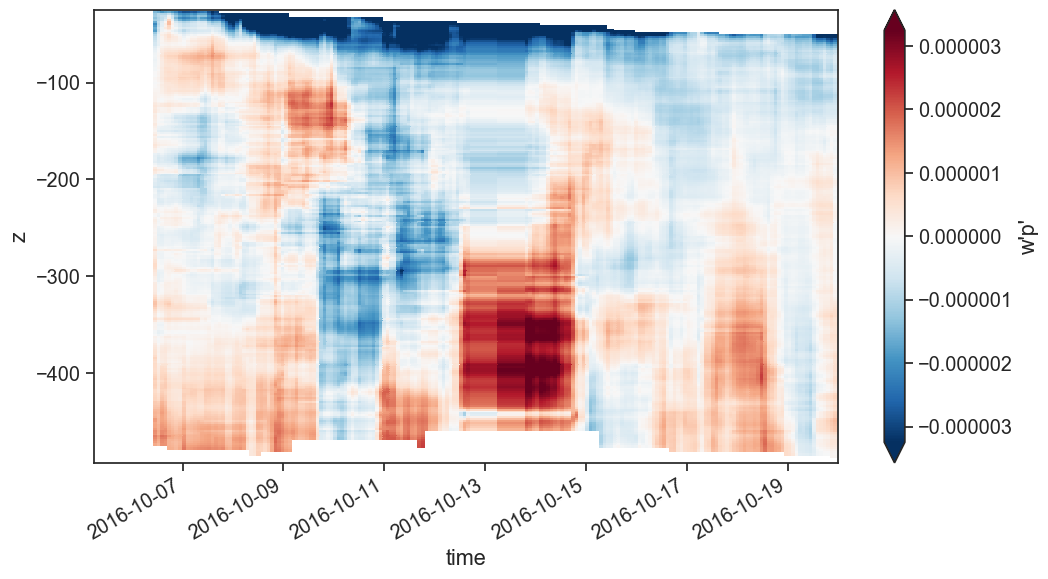

In [145]:
(wprime*prime0).rolling(time=18).mean().plot(robust=True,
                    cbar_kwargs={'label':"w'p'"})

## Spectra of p'

In [146]:
def compute_spectra_zmean(raw,array):
    raw['dtime'] = ('time', np.array( (raw.time - raw.time.isel(time=0)).values*1e-9, dtype=float))
    raw = raw.swap_dims({'time':'dtime'})
    return dsp.spectrogram(raw[array].dropna('z', how='all').mean('z'), dim='dtime',
                           fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )

def compute_spectra_resid(raw,array):
    raw['dtime'] = ('time', np.array( (raw.time - raw.time.isel(time=0)).values*1e-9, dtype=float))
    raw = raw.swap_dims({'time':'dtime'})
    return dsp.spectrogram(raw[array].dropna('z', how='all')-raw[array].dropna('z', how='all').mean('z'), dim='dtime',
                           fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )

In [147]:
raw['pprime'] = pprime

In [148]:
S_pprime = compute_spectra(raw, 'pprime').mean('dtime')
S_pprime_zmean = compute_spectra_zmean(raw, 'pprime').mean('dtime')
S_pprime_resid = compute_spectra_resid(raw, 'pprime').mean('dtime')

/Users/sebastianessink/Dropbox (MIT)/niw/src/niwtools/niwtools/tools.py:296: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  fs=86400/dsp.get_sampling_step(raw, dim='dtime'), nperseg=128 )
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  """
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UnevenSamplingWarning: Average sampling 6.43e+03 != first sampling step 9.73e+03
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Frequency [cpd]')

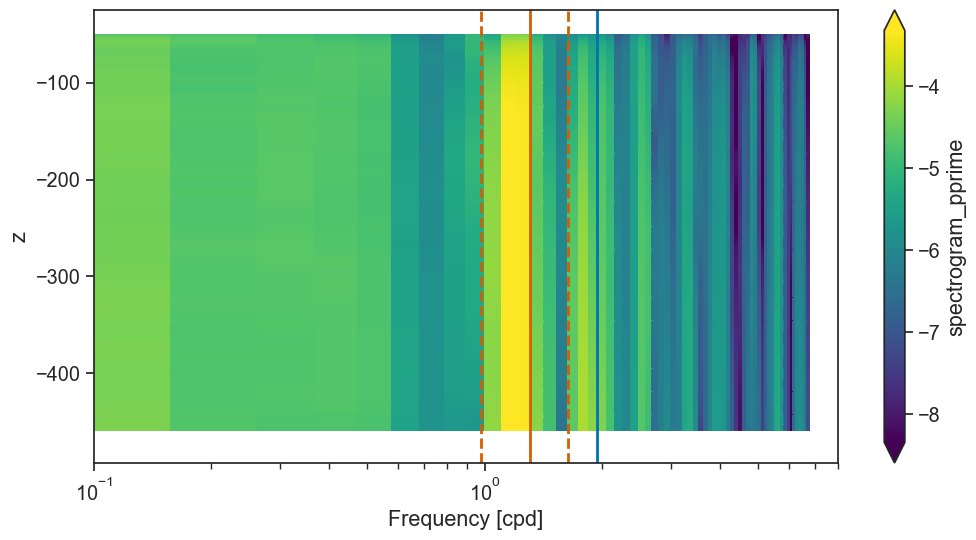

In [149]:
S_pprime.transpose().pipe(np.log10).plot(cmap='viridis', robust=True)
# ax[0].set_ylim(-400,-30)
plt.xlim(1e-1,8e0)
plt.xscale('log')

latmean = 40.7

m2freq = 24/(12+25/60)
plt.axvline(m2freq, lw=2, color='b')
plt.axvline(gsw.f(latmean)*86400/(2*np.pi), lw=2, color='r')
plt.axvline(0.75*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')
plt.axvline(1.25*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')

plt.xlabel('Frequency [cpd]')

Text(0.5, 0, 'Frequency [cpd]')

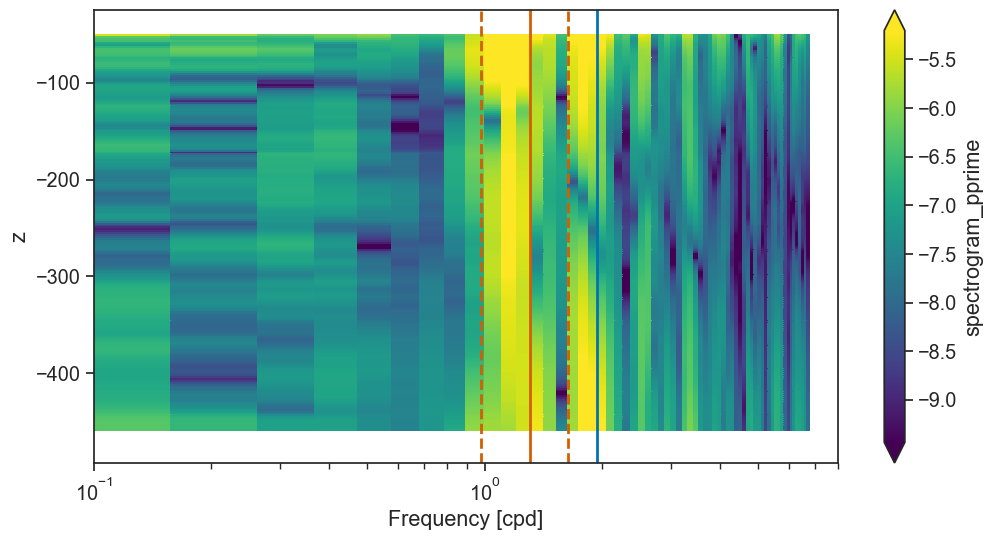

In [150]:
S_pprime_resid.transpose().pipe(np.log10).plot(cmap='viridis', robust=True)
# ax[0].set_ylim(-400,-30)
plt.xlim(1e-1,8e0)
plt.xscale('log')

latmean = 40.7

m2freq = 24/(12+25/60)
plt.axvline(m2freq, lw=2, color='b')
plt.axvline(gsw.f(latmean)*86400/(2*np.pi), lw=2, color='r')
plt.axvline(0.75*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')
plt.axvline(1.25*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='r')

plt.xlabel('Frequency [cpd]')

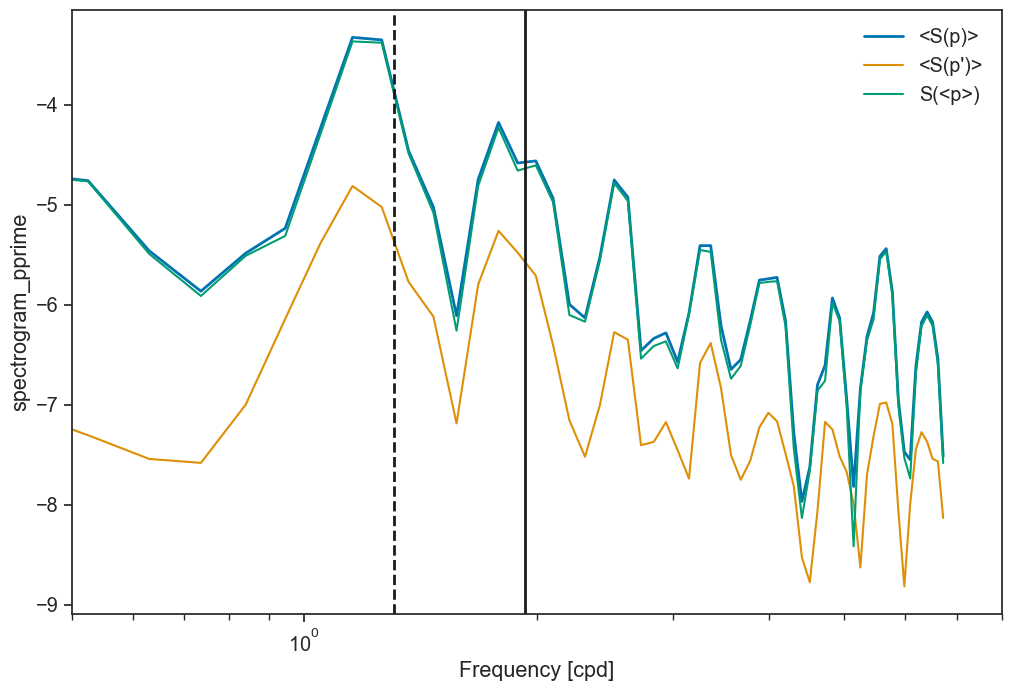

In [151]:
plt.figure(figsize=(12,8))
S_pprime.mean('z').pipe(np.log10).plot(label='<S(p)>', lw=2)
S_pprime_resid.mean('z').pipe(np.log10).plot(label="<S(p')>")
S_pprime_zmean.pipe(np.log10).plot(label=r'S(<p>)')
# plt.ylim(-1,2)
plt.xlim(5e-1,8e0)
plt.xscale('log')

latmean = 40.7

m2freq = 24/(12+25/60)
plt.axvline(m2freq, lw=2, color='k')
plt.axvline(gsw.f(latmean)*86400/(2*np.pi), lw=2, color='k', ls='dashed')
# plt.axvline(0.75*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='k')
# plt.axvline(1.25*gsw.f(latmean)*86400/(2*np.pi), ls='dashed', lw=2, color='k')

plt.xlabel('Frequency [cpd]')
plt.legend()

### Compute cgx, cgz, and omega

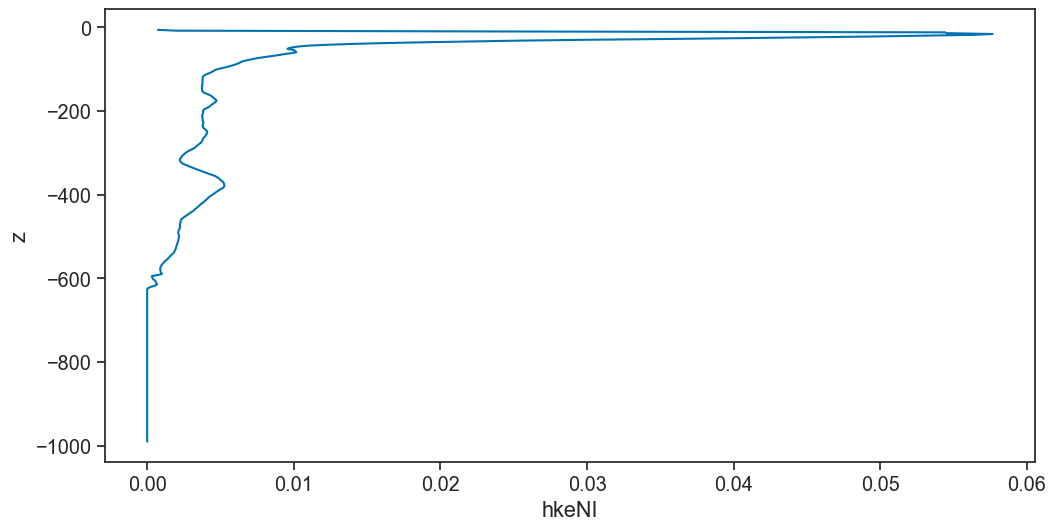

In [201]:
raw.hkeNI.mean('time').plot(y='z')

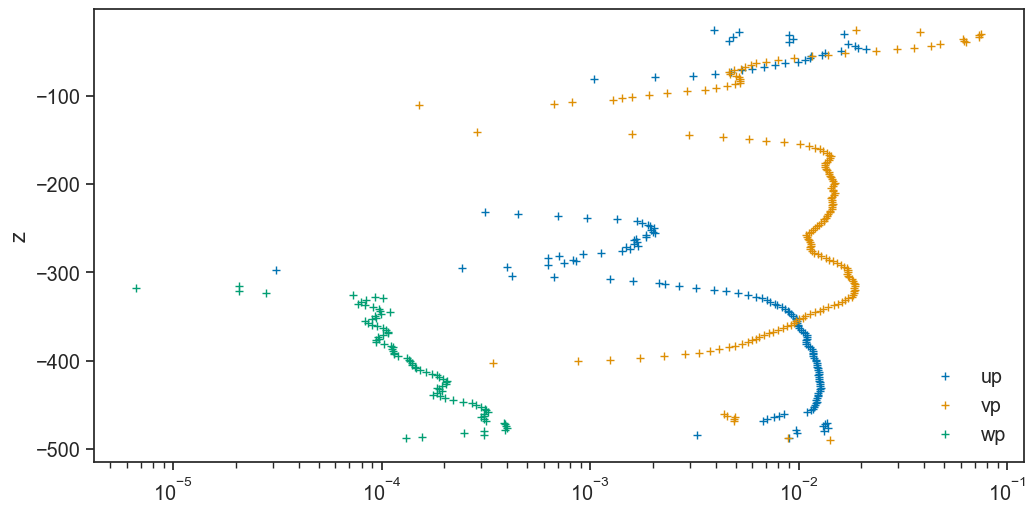

In [152]:
# raw['hkeNI'] = raw.hkeNI*(1025)
((uprime*prime0)/raw.hkeNI.mean('time')).mean('time').plot(y='z', label='up', marker='+', lw=0)
((vprime*prime0)/raw.hkeNI.mean('time')).mean('time').plot(y='z', label='vp', marker='+', lw=0)
((wprime*prime0)/raw.hkeNI.mean('time')).mean('time').plot(y='z', label='wp', marker='+', lw=0)
plt.xscale('log')
# plt.xlim(1e-5,1e-1)
plt.legend()

Text(0.5, 0, 'Group speed c$_g$ [m/s]')

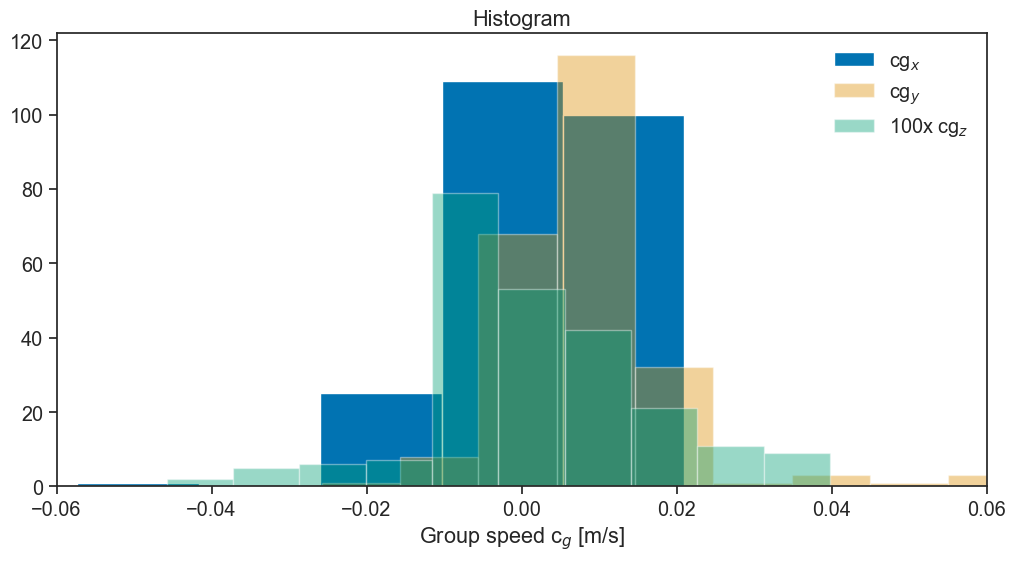

In [153]:
((uprime*prime0)/raw.hkeNI.mean('time')).mean('time').plot.hist(label=r"cg$_x$")
((vprime*prime0)/raw.hkeNI.mean('time')).mean('time').plot.hist(alpha=0.4,label=r"cg$_y$")
((wprime*prime0)/raw.hkeNI.mean('time')).mean('time').pipe(lambda x: x*100).plot.hist(alpha=0.4,label=r"100x cg$_z$")
# plt.xscale('log')
plt.xlim(-0.06,0.06)
plt.legend()
plt.xlabel('Group speed c$_g$ [m/s]')

In [154]:
cgz.max(),cgx.max()

(<xarray.DataArray ()>
 array(0.00039791), <xarray.DataArray ()>
 array(0.02101923))

In [160]:
cgx = ((uprime*prime0)/raw.hkeNI.mean('time')).mean('time')
cgz = ((wprime*prime0)/raw.hkeNI.mean('time')).mean('time')
r_cg = cgz/cgx

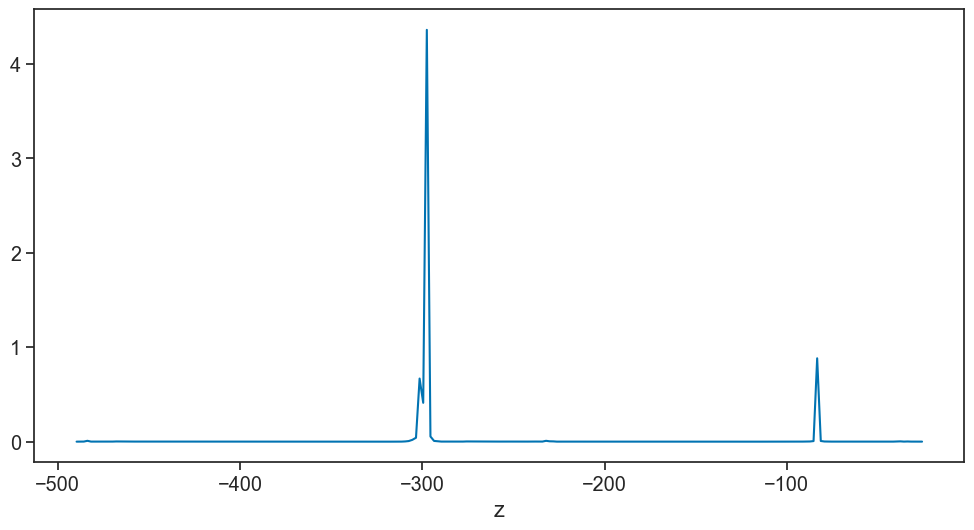

In [199]:
r_cg.pipe(np.square).plot()

In [161]:
f = gsw.f(40.7)

In [202]:
raw['n2'] = -9.81*raw.rho0.differentiate('z')/1025

In [203]:
omega = (raw.n2.mean('time')*r_cg**2 + gsw.f(40.7)**2).pipe(np.sqrt).pipe(lambda x: x/f)

In [204]:
omega.median()

<xarray.DataArray ()>
array(1.18269094)

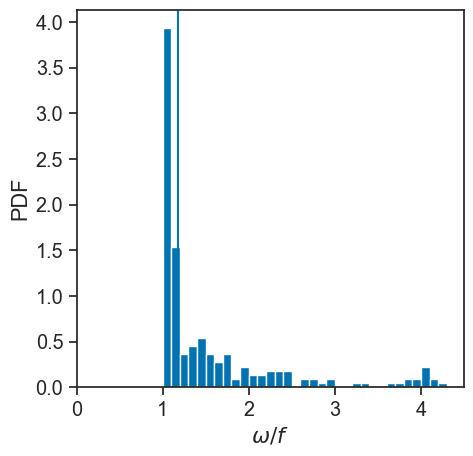

In [205]:
plt.figure(figsize=(5,5))
omega.plot.hist(range=(0,5), bins=50, density=True);
plt.axvline(1.18)
plt.xlabel(r'$\omega/f$')
plt.ylabel(r'PDF')
plt.title('')
plt.xlim(0,4.5);

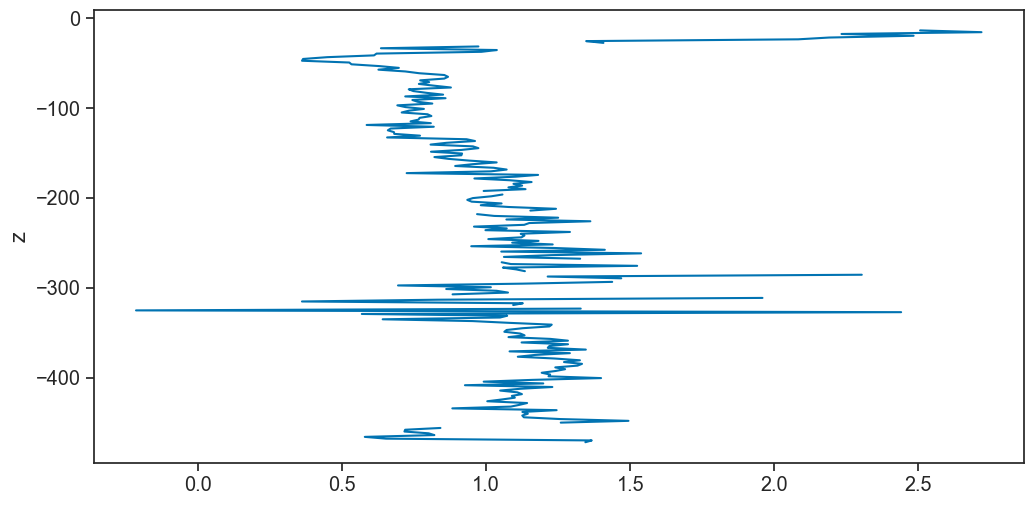

In [232]:
(raw.hkeNI/raw.ape).where(np.isfinite(raw.hkeNI/raw.ape)).mean('time').pipe(np.log10).plot(y='z')

In [233]:
r_e = (raw.hkeNI/raw.ape).where(np.isfinite(raw.hkeNI/raw.ape)).mean('time')

In [271]:
omega.median()

<xarray.DataArray ()>
array(1.18269094)

In [275]:
omega_e = (-f**2*(1+r_e)/(1-r_e)).pipe(np.sqrt).pipe(lambda x: x/f)

In [280]:
omega_e.median()

<xarray.DataArray ()>
array(1.08888074)

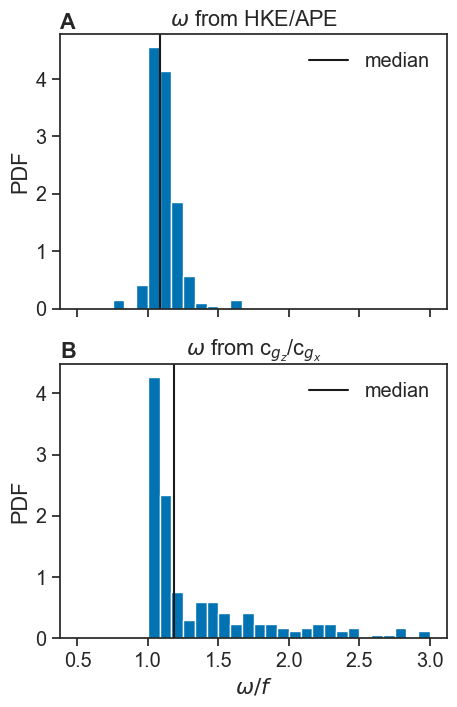

In [283]:
fig, ax = plt.subplots(2,1,figsize=(5,8), sharex=True)

omega_e.plot.hist(
    bins=30,ax=ax[0],range=(0.5,3), density=True)
ax[0].set_title('')
ax[0].set_title(r'$\omega$ from HKE/APE', loc='center')
ax[0].set_ylabel(r'PDF')
ax[0].axvline(omega_e.median(), color='k', label='median')
ax[0].legend()

omega.plot.hist(
    range=(0.5,3), bins=30, density=True,ax=ax[1]);
ax[1].set_title('')
ax[1].set_title(r'$\omega$ from c$_{g_z}$/c$_{g_x}$', loc='center')
ax[1].set_xlabel(r'$\omega/f$')
ax[1].set_ylabel(r'PDF')
ax[1].axvline(omega.median(), color='k', label='median')
ax[1].legend()

alphabet(ax)

plt.savefig('../figures/omegas_for_eric.pdf',dpi=500)

In [294]:
phase = xr.open_dataset('phase_data.nc')
phase.coords['z'] = -phase.z

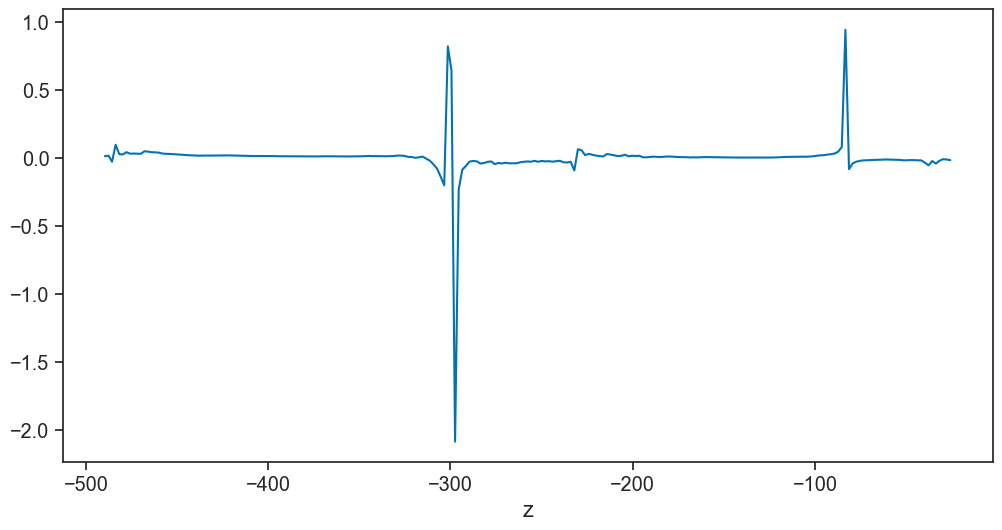

In [295]:
r_cg.plot()

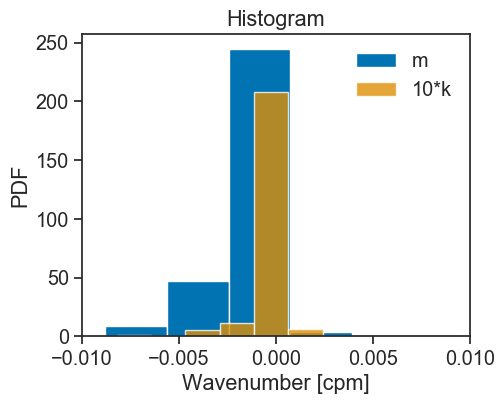

In [335]:
plt.figure(figsize=(5,4))
phase.hke_kz.mean('time').plot.hist(bins=30, label='m');
(-phase.hke_kz.mean('time')*r_cg).pipe(lambda x: x*10).plot.hist(bins=30,alpha=0.8, label='10*k')
plt.xlim(-1e-2,1e-2)
plt.xlabel('Wavenumber [cpm]')
plt.ylabel('PDF')
plt.legend()

plt.savefig('../figures/k_for_eric.pdf',dpi=500)